# Environmental Impact of Agricultural Practices in the World

**ADA Project Milestone 2**

This notebook consists of our initial Data Analysis of the FAOSTAT dataset on Food an agriculture. We will first study the contents of the data and its strucuture, before restructuring it in order to start our analysis. Also, some research questions initially asked will be answered by the end of this notebook.

## A. Initial Analysis

The dataset initially contained 78 csv files, but some of them were discarded as they will not be useful for our analysis. We have selected 25 CSVs that would help us with our analysis.

In [1]:
from glob import glob
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
csv_files = [x for x in glob('data/**/*.csv') if 'item_groups' not in x]
len(csv_files)

25

We split those 25 csv into different directories, one for each group of csv. Each group corresponds to one category:
```.
+-- data/
|   +-- emissions_agriculture/
|      +-- ...
|   +-- emissions_land/
|      +-- ...
|   +-- environment/
|      +-- ...
|   +-- inputs/
|      +-- ...
|   +-- population/
|      +-- ...
|   +-- production/
|      +-- ...
```

---
### A.1 Schema consistency
---

We will first study the schemas of all the csv files we have in order to see if they are consistent or require changes

#### 1. Checking column names across whole dataset
---

Now, let's scan all the csv files and check their schemas.

In [3]:
from data_processing import scan_columns
all_columns = scan_columns(csv_files)
print("The found columns, grouped, are:\n")
for cols, f in all_columns:
    print(list(sorted(cols)), f"Num files {len(f)}")

The found columns, grouped, are:

['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'unit', 'value', 'year', 'yearcode'] Num files 17
['country', 'countrycode', 'element', 'elementcode', 'elementgroup', 'flag', 'item', 'itemcode', 'unit', 'value', 'year'] Num files 2
['area', 'areacode', 'element', 'elementcode', 'flag', 'months', 'monthscode', 'unit', 'value', 'year', 'yearcode'] Num files 1
['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'note', 'unit', 'value', 'year', 'yearcode'] Num files 4
['country', 'countrycode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'unit', 'value', 'year', 'yearcode'] Num files 1


As we can see, sometimes the columns `area` and `areacode` are named `country` and `countrycode`, only because some csv files only contain country data, without country groups. We will rename those as to have a unified schema. Also, some files have the `note`, `elementgroup` and `months` columns. We will look into those in subsequent steps as we are now simply checking whether column naming is consistent.

In order to obtain a more consistent column naming, we will rename `country` to `area` and `countrycode` to `areacode`.

In [4]:
column_rename = {'country': 'area', 'countrycode': 'areacode'}

In [5]:
all_columns_2 = scan_columns(csv_files, column_rename)
print(f"After renaming, we obtain the following columns:\n")
for cols, f in all_columns_2:
    print(list(sorted(cols)), f"Num files {len(f)}")

After renaming, we obtain the following columns:

['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'unit', 'value', 'year', 'yearcode'] Num files 18
['area', 'areacode', 'element', 'elementcode', 'elementgroup', 'flag', 'item', 'itemcode', 'unit', 'value', 'year'] Num files 2
['area', 'areacode', 'element', 'elementcode', 'flag', 'months', 'monthscode', 'unit', 'value', 'year', 'yearcode'] Num files 1
['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'note', 'unit', 'value', 'year', 'yearcode'] Num files 4


#### 2. Checking which columns to drop
---

1. Column labeled "`note`"

Now we have a few files that have different schemas. One column that we should look into before continuing is `note`, as it is in 4 files.

In [6]:
from data_processing import get_column_unique_values

files_with_note = all_columns_2[-1][1]
note_values = get_column_unique_values(files_with_note, column_rename, None,['note'])
note_values

,note
0,NaN


As we can see, all values for this column are NaN, so we can safely drop the column.

2. Columns "`yearcode`" and "`elementgroup`"

We figured it would be useful to scan for duplicate columns in each dataframe (i.e. columns with different names but same values)

In [7]:
from data_processing import scan_column_duplicates
duplicates = scan_column_duplicates(csv_files, column_rename)
for c, f in duplicates:
    print(f"Duplicates for {c} in {len(f)} files")

Duplicates for [('yearcode', 'year')] in 23 files
Duplicates for [('elementgroup', 'elementcode')] in 1 files


As we can see, most files have `year` and `yearcode` columns which are equal. Hence, we can safely drop this column. However, for `elementgroup` and `elementcode`, they are equal in almost all CSV where they appear (1/2), but not all, so we cannot safely drop it without checking. We choose to keep `elementcode` when those two are equal, and keep them both when they are not.

Hence, we can define a list of columns to be checked and dropped; We drop them if they fulfill any of the following conditions:
 - NaN in all rows
 - Duplicate with another column

In [8]:
check_columns = ["note", "yearcode", "elementgroup"]
all_columns_3 = scan_columns(csv_files, column_rename, check_columns)
print(f"After renaming and dropping columns, we obtain the following columns:\n")
for cols, f in all_columns_3:
    print(list(sorted(cols)), f"Num files {len(f)}")

After renaming and dropping columns, we obtain the following columns:

['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'unit', 'value', 'year'] Num files 23
['area', 'areacode', 'element', 'elementcode', 'elementgroup', 'flag', 'item', 'itemcode', 'unit', 'value', 'year'] Num files 1
['area', 'areacode', 'element', 'elementcode', 'flag', 'months', 'monthscode', 'unit', 'value', 'year'] Num files 1


We now have 41 files with identical schemas, and 2 files that have a different one:
 - The file containing the `elementgroup` additional column, which refers to groups of `elements`
 - The file with monthly data and no `item` and `itemcode` columns
 
To obtain the desired format, we can now call `load_dataframe(<file>, column_rename, drop_columns)` with `column_rename = {'country': 'area', 'countrycode': 'areacode'}` and `drop_columns = ["note", "yearcode", "elementgroup"]`

The only remaining csv with different schema are:
- `data/environment/Environment_Temperature_change_E_All_Data_(Normalized).csv` (which contains monthly data)
- `data/environment/Environment_Energy_E_All_Data.csv`, which contains `elementgroup` column

---
### A.2 Schema description

---
Now that we have a unified schema for (almost) all csv files, we can start looking into the meaning of each column and their possible value. 

#### 1. Area columns
---
We will first look into the columns `area` and `areacode`. According to FAOSTAT's website, each area is defined by a unique areacode, however some areas include other ones, i.e. there are grouped areas in the datasets. We would expect a one-to-one mapping between those two columns. Let's see how this looks like

To verify that it is indeed a one-to-one mapping, we will append all values from all csv files, and drop duplicates. Then we group by area and see if the length of the group is 1.

In [9]:
from utils import is_unique_mapping

area_values = get_column_unique_values(csv_files, column_rename, check_columns, ['area', 'areacode'])
is_unique_mapping(area_values, 'area', ['areacode'])

False

It seems that the mapping is not one-to-one. Let's look into why that is. First we group by `areacode` and aggregate to a list of `area` and then we do the inverse. This way, we can see how the mapping is.

In [10]:
grpd = area_values.groupby('area')['areacode'].apply(list)
grpd[grpd.apply(lambda x: len(x) > 1)]

Series([], Name: areacode, dtype: object)

The mapping `area` -> `areacode` is unique, now for the opposite:

In [11]:
grpd = area_values.groupby('areacode')['area'].apply(list)
grpd[grpd.apply(lambda x: len(x) > 1)]

areacode
154     [The former Yugoslav Republic of Macedonia, No...
167                             [Czechia, Czech Republic]
209                                 [Eswatini, Swaziland]
299           [Occupied Palestinian Territory, Palestine]
5000                             [World, World + (Total)]
5100                           [Africa, Africa + (Total)]
5101           [Eastern Africa, Eastern Africa + (Total)]
5102             [Middle Africa, Middle Africa + (Total)]
5103         [Northern Africa, Northern Africa + (Total)]
5104         [Southern Africa, Southern Africa + (Total)]
5105           [Western Africa, Western Africa + (Total)]
5200                       [Americas, Americas + (Total)]
5203       [Northern America, Northern America + (Total)]
5204         [Central America, Central America + (Total)]
5206                     [Caribbean, Caribbean + (Total)]
5207             [South America, South America + (Total)]
5300                               [Asia, Asia + (Total)]
5301 

It seems that the same `areacode` is sometimes mapped to multiple `area`, most of the time by adding "+ (Total)". For that, we could drop the `area` column and keep working with `areacode`.

However, we still need a fixed database that maps the `areacode` to `area`, and for this, FAOSTAT provides one CSV file containing the mapping, as well as another one containing a description of country groups (i.e. "Asia") and which contries they contain.

In [12]:
from data_processing import load_dataframe
area_codes = load_dataframe('data/countries.csv')
area_codes.head()

,countrycode,country,m49code,iso2code,iso3code,startyear,endyear
0,2,Afghanistan,4.0,AF,AFG,NaN,NaN
1,5100,Africa,2.0,NaN,X06,NaN,NaN
2,284,Ã land Islands,248.0,NaN,ALA,NaN,NaN
3,3,Albania,8.0,AL,ALB,NaN,NaN
4,4,Algeria,12.0,DZ,DZA,NaN,NaN


In [13]:
country_groups = load_dataframe('data/country_groups.csv')
country_groups.head()

,countrygroupcode,countrygroup,countrycode,country,m49code,iso2code,iso3code
0,5100,Africa,4,Algeria,12.0,DZ,DZA
1,5100,Africa,7,Angola,24.0,AO,AGO
2,5100,Africa,53,Benin,204.0,BJ,BEN
3,5100,Africa,20,Botswana,72.0,BW,BWA
4,5100,Africa,24,British Indian Ocean Territory,86.0,IO,IOT


Here, countries are grouped into multiple `countrygroup`, so we know exactly of which countries each group is formed. These country groups are present in the dataset as `area`, meaning there are aggregated values in the dataset. For example: we can find the emissions for "Algeria" and for "Africa", where the latter is an aggregated value over the whole group. We will need to be careful when aggregating values in the future, as we could account multiple times for one country.

In [14]:
is_unique_mapping(area_codes[['country', 'countrycode']].drop_duplicates(), 'country', ['countrycode'])

True

In [15]:
all(x in area_codes.countrycode.unique() for x in area_values.areacode.unique())

True

Hence, we can use the dataframe `area_codes` to obtain the country's name from it's code, and `country_groups` to get which countries form a group. For this, we can now drop the `area` column in our dataset.

#### 2. Element Columns
---

The `element` and `elementcode` represent the measure quantity for a given `item`. A quantity has a name and a unit, which is why we believe these two columns should also have a one-to-one mapping accross the whole dataset. Also, since an `elementcode` potentially uniquely identifies (`element`, `unit`) pair, we might drop those two columns as to make the csv files smaller and easier to manipulate.

First let's check if indeed this mapping is one-to-one:

In [16]:
element_values = get_column_unique_values(csv_files, column_rename, check_columns, ['elementcode', 'element', 'unit'])
is_unique_mapping(element_values, 'elementcode', ['element', 'unit'])

True

As we can see, `elementcode` uniquely identify (`element`, `unit`) pairs, so we can safely drop those two columns and only use `elementcode`. We will later pivot each csv as to obtain all the `elementcode`s as columns, so we can reduce de number of rows significantly. A mapping using a dictionnary will of course be necessary in order to have a nice GUI where users can select the (element, unit) pair instead of the code.

#### 3. Item columns
---

According to FAOSTAT, the `item` and `itemcode` columns represent item on which measurements were done. For example an item can be `cattle` and the measurement can be "CH4 emissions in gigagrams". 
Similarly to what we did above, we expect `item` and `itemcode` to have a one-to-one relationship. Let's verify this using the same functions

In [17]:
item_values = get_column_unique_values(csv_files, column_rename, check_columns, ['item', 'itemcode'], with_file=True)
is_unique_mapping(item_values[['item', 'itemcode']], 'item', ['itemcode'])

False

It seems that `item` to `itemcode` is not unique for a few items, let's check those and try to understand why it is the case.

In [18]:
grpd = item_values.groupby('itemcode')['item'].agg(set)
grpd[grpd.apply(len) > 1]

Series([], Name: item, dtype: object)

The mapping `itemcode` -> `item` is unique, now let's check the other way around

In [19]:
grouped = item_values.groupby('item')['itemcode'].agg(set)
grouped[grouped.apply(len) >1]

item
Ammonium nitrate (AN)                            {1362, 4003}
Ammonium sulphate                                {1361, 4002}
Cattle                                            {866, 1757}
Chickens                                         {1057, 1054}
Disinfectants                                    {1358, 1351}
Mineral Oils                                     {1354, 1316}
Other Pesticides nes                             {1355, 1359}
Other nitrogenous fertilizers, n.e.c.            {4008, 1369}
Other potassic fertilizers, n.e.c.               {4018, 1391}
Plant Growth Regulators                          {1356, 1341}
Potassium sulphate (sulphate of potash) (SOP)    {4017, 1387}
Urea                                             {4001, 1367}
Name: itemcode, dtype: object

Some items seem to have multiple different item codes, which doesn't seem very normal. 

**a.** It seems that some of those items correspond to nutrients provided throught fertilizers. Let's see in which files those appear. The items related to nutrients are the following :

In [20]:
nutrient_items = ["Ammonium nitrate (AN)", "Ammonium sulphate", "Other nitrogenous fertilizers, n.e.c.", "Other potassic fertilizers, n.e.c.", "Potassium sulphate (sulphate of potash) (SOP)", "Urea"]
item_values[item_values.item.isin(nutrient_items)].file.unique()

array(['data/inputs/Inputs_FertilizersArchive_E_All_Data_(Normalized).csv',
       'data/inputs/Inputs_FertilizersProduct_E_All_Data_(Normalized).csv'],
      dtype=object)

Those items are only present in two dataframes, related to Ferilizer use. If we look closely at the names of csv files, we can see that one of them is "Archive", 
while the other is product. After having looking and reading the documentation for this CSV http://www.fao.org/faostat/en/#data/RA, we understand that it is an archive document, that has not been updated since 2002. 

Before that date, all data on Fertilizer was put into one single dataframe (i.e. info about production, trade and consumption) both in total nutrients and amount of product. After 2002, it was split into nutrient and product, which is why we have two `itemcode` values for those `items`. 

Hence, we should be careful when studying the fertilizer use, as data collection has changed in 2002.


**b.** Some items are related to pesticides. Let's in which csv files they appear

In [21]:
pesticide_items = ["Disinfectants", "Mineral Oils", "Other Pesticides nes", "Plant Growth Regulators"]
item_values[item_values.item.isin(pesticide_items)].file.unique()

array(['data/inputs/Inputs_Pesticides_Use_E_All_Data_(Normalized).csv'],
      dtype=object)

Some duplicate items with the same name but different codes appear in only one csv file, which seems quite odd. We suspect having duplicate rows in that case. Let's check that out.

In [22]:
from data_processing import check_duplicate_items
t = load_dataframe('data/inputs/Inputs_Pesticides_Use_E_All_Data_(Normalized).csv', column_rename, check_columns)
check_duplicate_items(t, pesticide_items)

Duplicate item for Disinfectants codes [1358 1351]
Duplicate item for Mineral Oils codes [1354 1316]
Duplicate item for Other Pesticides nes codes [1359 1355]
Duplicate item for Plant Growth Regulators codes [1356 1341]


We now know that there are potentially duplicate rows for the same `item` but a different `itemcode` (with the same measurements). Hence, we need to add a functionnality that checks for duplicated items in the dataframe.

**c.** Now let's look at livestock items

In [23]:
livestock_items = ["Cattle", "Chickens"]
for i in item_values[item_values.item.isin(livestock_items)].groupby(['item', 'itemcode']).agg(set).reset_index().values:
    print(i)

['Cattle' 866
 {'data/production/Production_Livestock_E_All_Data_(Normalized).csv'}]
['Cattle' 1757
 {'data/emissions_agriculture/Emissions_Agriculture_Manure_left_on_pasture_E_All_Data_(Normalized).csv', 'data/emissions_agriculture/Emissions_Agriculture_Enteric_Fermentation_E_All_Data_(Normalized).csv', 'data/emissions_agriculture/Emissions_Agriculture_Manure_applied_to_soils_E_All_Data_(Normalized).csv', 'data/emissions_agriculture/Emissions_Agriculture_Manure_Management_E_All_Data_(Normalized).csv'}]
['Chickens' 1054
 {'data/emissions_agriculture/Emissions_Agriculture_Manure_left_on_pasture_E_All_Data_(Normalized).csv', 'data/emissions_agriculture/Emissions_Agriculture_Manure_applied_to_soils_E_All_Data_(Normalized).csv', 'data/emissions_agriculture/Emissions_Agriculture_Manure_Management_E_All_Data_(Normalized).csv'}]
['Chickens' 1057
 {'data/production/Production_Livestock_E_All_Data_(Normalized).csv'}]


The `itemcode` -> `item` seems one-to-one in each csv file, but we see that there are two distinct `itemcode` for "Cattle" and "Chickens" accross all csv files.

It seems that different values for `itemcode` for both "Chickens" and "Cattles" differ when the measured quantity is realted to emissions. Thus, this might be a discrepancy in the data as it does not appear for other items. We will treat this discrepancy once all csv have been merged into one.

#### 4. Flag Columns
---

According to FAOSTAT, not all the data points are official figures reported by individual countries. Some are estimates, others are aggregates done by external entities. In order to understand the meaning of those flagas, they provide a csv file containing the description of each.

In [24]:
flags = load_dataframe("data/flags.csv")
flags.head()

,flag,flags
0,NaN,Official data
1,*,Unofficial figure
2,A,"Aggregate, may include official, semi-official..."
3,B,Balance
4,Bk,Break in series


In [25]:
print(f"There are {len(flags)} flags")

There are 41 flags


---
### A.3 Conclusion about Schemas

---

After having applied some analysis on the initially different schemas of the dataframes, we are now able to obtain identitcal schemas for 41 of them, and left two of them where we believe they should not be changed as some information could be lost.

The common schema has the following columns:

`['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'unit', 'value', 'year']`

For now, we have come up with a few steps that should be applied when loading a dataframe:
 - Rename columns to remove spaces and captial letters
 - Rename "Country" to "Area" and "CountryCode" to "Areacode"
 - Drop columns that are either duplicates or NaN values
 - Rename "gigagrams" to "Gigagrams", as otherwise we would have a non one-to-one mapping for `elementcode`
 - Check for items if they have duplicate rows.

The function that does the first 4 cleaning steps is `data_processing/load_dataframe`, and the one that puts everything together is `data_processing/load_clean_dataframe`.

Also, we have decided to only work with codes (i.e. `areacode` and `elementcode`) and drop `area`, `element` and `unit`. Of course, we will need a mapping from `code` -> `value`. Additionally, in order to keep track of `countrygroup` and do know how values are aggregated, we will also create a mapping that tells us which countries form a group, by codes.

Hence, to load a dataframe, we simply call :
```
df = load_clean_dataframe(<filename>, column_rename, check_columns, drop_columns)
```

with  `column_rename = {'country': 'area', 'countrycode': 'areacode'}` and `check_columns = ["note", "yearcode", "elementgroup"]` and `drop_columns = ["area", "item", "element", "unit"]`

In [26]:
column_rename = {'country': 'area', 'countrycode': 'areacode'}
check_columns = ["note", "yearcode", "elementgroup"]
drop_columns = ["area", "item", "element", "unit"]

Now we need to get the mappings for :
- `elementcode` -> (`element`, `unit`) (unique in both ways)
- `itemcode` -> `item` (unique in that way, but not the other way around)
- `areacode` -> `area` (unique in both ways)

In [27]:
from mappings import get_mapping, get_area_mapping, get_country_groups
item_mapping = get_mapping(csv_files, column_rename, check_columns, ['itemcode','item'])
element_mapping = get_mapping(csv_files, column_rename, check_columns, ['elementcode', 'element', 'unit'])


In [28]:
from mappings import get_area_mapping, get_country_groups
area_mapping = get_area_mapping("data/countries.csv")
country_groups = get_country_groups("data/country_groups.csv")

---
---
## B. Diving into the data

For now everything was stored in database format (i.e. Row format), but we would like to have elements in columns, so that we can reduce drastically the number of rows, and so we can have all the measurements for a single (`itemcode`, `areacode`, `year`) pair.

---
### B.1 Merging all files with same schema

---

Before reshaping, we know that 41 csv files have the same schema. Thus, it would be good to have them all in a single dataframe in order to facilitate access to values. We will then create a single dataframe from all those 41 (over 43 in total). This dataframe will then have potentially duplicate rows, which we will drop.

In [30]:
from data_processing import load_clean_dataframe, load_all_df_with_schema
schema = ['area', 'areacode', 'element', 'elementcode', 'flag', 'item', 'itemcode', 'unit', 'value', 'year']
df = load_all_df_with_schema(csv_files, schema, column_rename, check_columns, drop_columns)

Dropped duplicate item Disinfectants with codes [1358, 1351] (Dropped 1351)
Dropped duplicate item Mineral Oils with codes [1354, 1316] (Dropped 1316)
Dropped duplicate item Other Pesticides nes with codes [1359, 1355] (Dropped 1355)
Dropped duplicate item Plant Growth Regulators with codes [1356, 1341] (Dropped 1341)
Dropped 725925 duplicate rows


In [31]:
import gc
gc.collect()

2736

---
### B.2 Selecting subsets of items for our study
---

We currenlty have around 450 items in our dataframe. This number is quite large and we could not select items arbitrarily to do our study. For this we have decided to used `itemgroups`, which are simply groups of items defined by FAOSTAT. 

For some provided csv file, FAOSTAT provides another csv containing `itemgroup` and from which items they are formed. Those values are already present in our dataset, hence we only need to filter out `itemcode` values that are not an `itemgroup`.

In [64]:
from data_processing import load_item_groups
files = glob("data/item_groups/*.csv")
item_groups = load_item_groups(files)

In [66]:
print("We can group {} items into {} item groups".format(item_groups.itemcode.nunique(), item_groups.itemgroupcode.nunique()))

We can group 257 items into 39 item groups


Now let's check that all `itemcode` present in the database are in the `item_groups`

In [67]:
set(item_groups.itemcode.unique()).difference(set(df.itemcode.unique()))

set()

And now item groups:

In [71]:
for i in set(item_groups.itemgroupcode.unique()).difference(set(df.itemcode.unique())):
    print(item_groups[item_groups.itemgroupcode == i].itemgroup.unique())

['Hides and skins, primary']
['Crops Primary']
['Live Animals']


It seems that only 3 item groups are not present in the dataframe. We don't really need "Hides and skins", as they are taken into consideration in other groups. As for "Crops Primary" and "Live Animals", they consider all groups so we don't really need them and can recompute them when needed.

In [77]:
itemcode_to_drop = set(item_groups.itemcode.unique())
df = df[~df.itemcode.isin(itemcode_to_drop)]

---
### B.3 Checking for duplicate measurements

---

Ideally, we would like to have a single row for each (`areacode`, `itemcode`, `elementcode` and `year`), i.e one measurement. Let's check if it is the case:

In [78]:
grouped = df.groupby(['areacode', 'itemcode', 'elementcode', 'year'])[['value', 'flag']].nunique(dropna=False).reset_index()
grouped['value'].value_counts(dropna=False) / grouped.shape[0]

1    0.997305
2    0.002695
Name: value, dtype: float64

As we can see, it is not the case:
    - Most of the time there is one measurement (~99.9%)
    - Some have two measurements (~0.1%)
This could be due to different `value` and/or different `flag`

Let's look at those values

#### 1. Assessing Elements that have duplicates
---

In order to remediate to this issue, we will look at the differences between the values, when there are multiple ones, and group by `elementcode`

In [79]:
from utils import get_percentage_diff

def get_discrepancies(df):
    indexed = df.set_index(['areacode', 'itemcode', 'elementcode', 'year']) # Set the index to what what should be unique
    duplicated_1 = indexed.index.duplicated(keep='first')  # Take the first duplicate
    duplicated_2 = indexed.index.duplicated(keep='last')  # Take the second one
    joined = indexed.loc[duplicated_1].join(indexed.loc[duplicated_2], rsuffix='_2')  # Join on the index to have both values and indices
    return joined

def get_discrepancies_by(df,by):
    discrepancies_by = df.reset_index().groupby(by)\
                                 .apply(lambda x: pd.Series({'mean_diff': np.mean(x['value'] - x['value_2']), # Mean difference
                                                             'std': np.std(x['value'] - x['value_2']),        # STD of difference
                                                             'num': x.shape[0],                                 # Number of different values
                                                             'mean_perc_diff': np.mean(get_percentage_diff(x['value'], x['value_2'])*100)})) # Average difference in percentage
    return discrepancies_by.sort_values('mean_perc_diff')

In [80]:
joined = get_discrepancies(df)
get_discrepancies_by(joined, ['file', 'file_2']).reset_index()

,file,file_2,mean_diff,std,num,mean_perc_diff
0,data/emissions_agriculture/Emissions_Agricultu...,data/production/Production_Livestock_E_All_Dat...,-2.012377e+07,4.860929e+07,290.0,3.250796
1,data/emissions_agriculture/Emissions_Agricultu...,data/environment/Environment_Emissions_by_Sect...,5.025583e+02,4.838841e+03,14287.0,5.326875
2,data/emissions_land/Emissions_Land_Use_Land_Us...,data/environment/Environment_Emissions_by_Sect...,2.293806e+03,9.149522e+03,5177.0,88.779951


In the above DataFrame, we have the `mean_diff` (mean difference between values), `std` and `mean_perc_diff` (mean percentage difference), grouped by files.
Hence, each line gives us a description of how much the same measurements differ on average, between the two files where they are present.

It seems that the csv file `data/environment/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv` introduces a lot of discrepancies, which might be due to different techniques of estimating measurements. Let's see which (`itemcode`, `elementcode`) pairs are affected by this discrepancy


In [81]:
tmp = joined[joined.file_2 == "data/environment/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv"].reset_index()
print("{:.2f} % of discrepancies come from Emissions by sector\n\n Discrepancies are in the item/element pairs :".format((tmp.shape[0] / joined.shape[0]) * 100))
tmp[['itemcode', 'elementcode']].drop_duplicates()#.apply(lambda x: pd.Series({'item': item_mapping[x['itemcode']], 'element': element_mapping[x['elementcode']]}), axis=1)

98.53 % of discrepancies come from Emissions by sector

 Discrepancies are in the item/element pairs :


,itemcode,elementcode
0,1707,7243
11,1707,7244
5177,1711,7231
5197,1711,7244
5213,1711,7243


Thus, since we know that for all these pairs we have duplicate values, we choose to drop those who come from `data/environment/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv`. The reason we choose to drop those is because we want to stay consistent and rely on one method of measurement, which is the `emissions_land` and `emissions_agriculture`

In [82]:
dup = df.set_index(['areacode', 'itemcode', 'elementcode', 'year']).index.duplicated(keep=False)
from_emissions_by_sector = df[dup & (df.file == "data/environment/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv")]
df = df.drop(from_emissions_by_sector.index)

In [83]:
joined = get_discrepancies(df)

Now that we have dropped the potentially problematic rows, we will print the same statistics, but grouped by areacode.

In [84]:
by_area = get_discrepancies_by(joined, 'areacode')#.sort_values(['num', 'mean_perc_diff'])
by_area.index = [area_mapping[i] for i in by_area.index]
by_area[by_area['std'] > 0].sort_values('std')

,mean_diff,std,num,mean_perc_diff
Asia,-1.666667e+00,4.714045e-01,3.0,1.584453e-07
Zambia,0.000000e+00,1.000000e+00,2.0,3.387576e-05
Eastern Africa,0.000000e+00,1.000000e+00,2.0,4.247949e-07
Guadeloupe,0.000000e+00,1.000000e+00,2.0,8.735449e-03
Djibouti,0.000000e+00,1.000000e+00,2.0,1.016351e-04
Jamaica,0.000000e+00,1.000000e+00,2.0,1.788757e-04
Equatorial Guinea,0.000000e+00,1.000000e+00,2.0,2.003421e-03
Netherlands Antilles (former),0.000000e+00,1.000000e+00,2.0,4.201411e-03
Saint Lucia,0.000000e+00,1.000000e+00,2.0,5.088646e-03
Central America,5.000000e-01,1.500000e+00,2.0,8.140472e-06


It seems that problematic areas are in area groups. Since we already know how area groups are formed, we can drop all values that are associated to a group and recompute them using `country_groups`

In [85]:
group_codes = set(country_groups.keys())
df = df[~df.areacode.isin(group_codes)]  # Drop all country groups

In [86]:
joined = get_discrepancies(df)
(joined.value - joined.value_2).describe()

count    66.000000
mean     -0.060606
std       1.005811
min      -1.000000
25%      -1.000000
50%      -1.000000
75%       1.000000
max       1.000000
dtype: float64

As we can see, now most differences have a very small mean and standard deviation. Also, there are only 70 duplicate measurements. In order to have unique ones, we will take the average of the two values

#### 2. Taking care of duplicate measurements
---

Now that we have understood where the big differences in duplicates appear, we focus on those that are still here, but are quite small. In order to get rid of duplicate measurements, we will work with a combination of the `value` and `flag` columns.

In [87]:
def is_close(value_1, value_2, threshold=0.01):
    diff = get_percentage_diff(value_1, value_2)
    return (value_1 == value_2) | (diff < threshold) | (value_1.isna() & value_2.isna())

def is_same_flag(flag_1, flag_2):
    return (flag_1 == flag_2) | (flag_1.isna() & flag_2.isna())

In [88]:
close = joined[is_close(joined.value, joined.value_2)]
same_flag = joined[is_same_flag(joined.flag, joined.flag_2)]

print("{:.2f}% of duplicated rows have a difference less than 1%".format(close.shape[0] / joined.shape[0] * 100))
print("{:.2f}% of duplicated rows have the same flag".format(same_flag.shape[0]/ joined.shape[0]*100))

100.00% of duplicated rows have a difference less than 1%
100.00% of duplicated rows have the same flag


Since most duplicated measurements'values are really close, we will take the mean if there are two different values.

In [89]:
df = df.drop(columns=['file', 'flag']).drop_duplicates().groupby(['areacode', 'itemcode', 'elementcode', 'year'])['value'].mean().reset_index()

In [106]:
df.to_pickle("data/df_cleaned.pkl")

---
### B.4 Reshaping measurements as columns
---

Now that we have unique measurements, we will reshape the dataframe to put each measurement for an item as column, so that for each (`areacode`, `itemcode`, `year`) we have all the measurements as columns.

In [107]:
reshaped_df = df.set_index(['areacode', 'itemcode', 'elementcode', 'year'])['value'].unstack(level=2).reset_index()

In [108]:
reshaped_df.to_pickle("data/reshaped_df.pkl")

In [109]:
reshaped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841606 entries, 0 to 841605
Columns: 130 entries, areacode to 724410
dtypes: float64(127), int64(3)
memory usage: 834.7 MB


In [112]:
df.elementcode.nunique(), df.itemcode.nunique(), df.areacode.nunique()

(127, 181, 249)

The overall dataframe is 2 GB, so it easily fits in memory.

We have 127 elements, 181 items and 249 area codes

---
---
## C. Studying the 

For now everything was stored in database format (i.e. Row format), but we would like to have elements in columns, so that we can reduce drastically the number of rows, and so we can have all the measurements for a single (`itemcode`, `areacode`, `year`) pair.

---
### B.4 Studying the time series
---

Now that the data has been reshaped, we will start studying the different time series we have. For this, we will start by analyzing the lengths, as well as the number of measurements.

In [34]:
reshaped_df = pd.read_pickle("data/reshaped_df.pkl")

Our database contains estimates for future years, but we do not want to take those into account as we only want factual (almost) data, and not forecasted.

In [35]:
reshaped_df = reshaped_df[reshaped_df.year.apply(lambda x: x < 2020)]

#### 1. Studying the lengths of time series
---

As a first step, we would like to look at how much data we have for each (`areacode`, `itemcode`), and potentially drop ones where we do not have enough data

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from utils import get_ts_stats

In [37]:
ts_stats = get_ts_stats(reshaped_df)

In [38]:
ts_stats.head(1)

,,years,cols
itemcode,areacode,,
15,1,"[1992, 1993, 1994, 1995, 1996, 1997, 1998, 199...","[5312, 5419, 5510, 7245, 72247, 72257, 72292, ..."


Now this dataframe contains the following information, for each (`itemcode`, `areacode`) pair:
- The available years where we have datapoints
- The available columns (i.e. measurements) we have for this pair

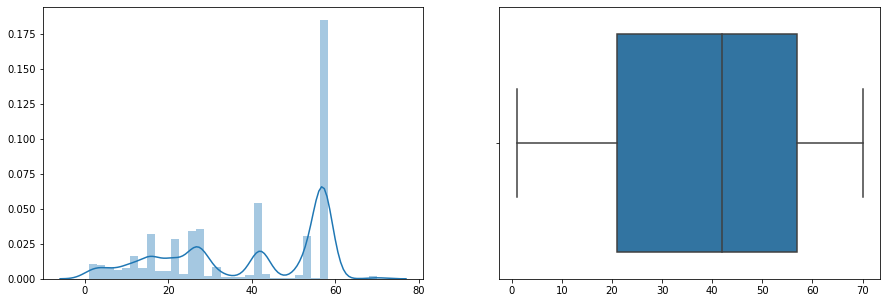

In [39]:
length_df = ts_stats.years.apply(len)

fig, ax = plt.subplots(figsize=(15, 5), ncols=2)
sns.distplot(length_df.values, ax=ax[0])
sns.boxplot(length_df.values, ax=ax[1])

In [40]:
length_df.describe()

count    48106.000000
mean        38.085727
std         18.698550
min          1.000000
25%         21.000000
50%         42.000000
75%         57.000000
max         70.000000
Name: years, dtype: float64

As we can see, the mean length of a time series is `39`, with a standard deviation of 18, and a minimum of 1. It makes sense to drop time series that have less than an arbitrary number of points as they will not be useful for conducting an analysis or training a model. We will drop all time series with less than 10 observations.

In [41]:
to_drop = set(length_df[length_df < 10].index.values)  # Get the (areacode, itemcode) where there are less than 10 observations
reshaped_df = reshaped_df[reshaped_df.apply(lambda x: (x['itemcode'], x['areacode']) not in to_drop, axis=1)]  # Remove them from dataframe

#### 2. Checking all itemcodes have the same elementcode columns
---

As a second step, we would like to know whether `itemcodes` have the same `elementcode` columns for all `areacodes`.

In [79]:
from data_processing import load_dataframe
item_groups_crops = load_dataframe("data/item_groups/Livestock_Primary_All_data.csv")

In [80]:
sorted(reshaped_df[reshaped_df.itemcode.isin(item_groups_crops.itemgroupcode.unique())].itemcode.unique())

[1765, 1770, 1775, 1780, 1783, 1806, 1807, 1808]

In [81]:
sorted(item_groups_crops.itemgroupcode.unique())

[1765, 1770, 1775, 1777, 1780, 1783, 1806, 1807, 1808]

In [84]:
item_groups_crops[['itemgroupcode', 'itemgroup']].drop_duplicates().sort_values('itemgroupcode')

,itemgroupcode,itemgroup
39,1765,"Meat, Total"
14,1770,"Meat indigenous, total"
9,1775,"Meat indigenous, poultry"
4,1777,"Hides and skins, primary"
60,1780,"Milk, Total"
2,1783,Eggs Primary
0,1806,Beef and Buffalo Meat
65,1807,Sheep and Goat Meat
34,1808,"Meat, Poultry"


In [78]:
len(item_groups_crops.itemcode.unique())

19

In [55]:
item_groups_crops[['itemgroup', 'itemgroupcode']].drop_duplicates()

,itemgroup,itemgroupcode
0,Cereals (Rice Milled Eqv),1817
15,"Cereals, Total",1717
30,"Citrus Fruit, Total",1804
35,"Coarse Grain, Total",1814
48,Crops Primary,1714
208,Fibre Crops Primary,1753
219,Fruit Primary,1738
258,"Oilcrops, Cake Equivalent",1841
274,"Oilcrops, Oil Equivalent",1732
297,"Pulses, Total",1726


In [ ]:
reshaped_df[reshaped_df.itemcode == ]

In [192]:
items_grouped[items_grouped.apply(len) == 1]

itemcode  item                     
89        Buckwheat                    {data/production/Production_Crops_E_All_Data_(...
92        Quinoa                       {data/production/Production_Crops_E_All_Data_(...
94        Fonio                        {data/production/Production_Crops_E_All_Data_(...
97        Triticale                    {data/production/Production_Crops_E_All_Data_(...
101       Canary seed                  {data/production/Production_Crops_E_All_Data_(...
                                                             ...                        
6819      Other sources                {data/environment/Environment_Emissions_by_Sec...
6821      Energy total                 {data/environment/Environment_Emissions_by_Sec...
6822      Land use sources             {data/environment/Environment_Emissions_by_Sec...
6823      Sources total                {data/environment/Environment_Emissions_by_Sec...
6825      Sources total excl. AFOLU    {data/environment/Environment_Emiss

In [82]:
ts_stats = get_ts_stats(reshaped_df).reset_index()

In [83]:
ts_stats['cols'] = ts_stats.cols.apply(lambda x: tuple(list(sorted(x))))

In [85]:
ts_stats = ts_stats.drop('years', axis=1)


In [90]:
element_stats = ts_stats.groupby(['itemcode', 'cols'])['areacode'].apply(list).reset_index()

In [119]:
tmp = element_stats.set_index('itemcode')
different_elements = tmp.index[tmp.index.duplicated(keep="first")]
different_elements = element_stats[element_stats.itemcode.isin(different_elements)]

In [122]:
different_elements.shape[0] / 2

296.0

In [123]:
different_elements

,itemcode,cols,areacode
1,27,"(5312, 5419, 5510, 7245, 72245, 72247, 72255, ...","[2, 3, 4, 7, 9, 10, 16, 18, 19, 21, 23, 25, 26..."
2,27,"(5312, 5419, 5510, 7245, 72247, 72257, 72292, ...",[191]
3,44,"(5312, 5419, 5510, 72292, 72302, 72312, 72342,...","[1, 2, 3, 4, 9, 10, 11, 15, 16, 18, 19, 21, 27..."
4,44,"(5510,)",[99]
9,83,"(5312, 5419, 5510, 72292, 72302, 72312, 72342,...","[3, 4, 7, 9, 10, 11, 16, 19, 20, 21, 23, 27, 2..."
...,...,...,...
777,6794,"(7245, 7246, 72259, 72309, 72319, 72439, 72449)","[5, 6, 8, 13, 14, 17, 22, 25, 35, 36, 47, 55, ..."
786,6807,"(72182, 72184, 719410, 719509, 719610, 719710,...","[1, 2, 3, 4, 9, 10, 11, 13, 14, 16, 19, 20, 21..."
787,6807,"(72182, 72184, 719610, 719710, 722510, 723010,...","[51, 62, 228, 248, 351]"
788,6808,"(72184, 719410, 719509, 719610, 719710, 722510...","[2, 3, 4, 8, 9, 10, 11, 13, 16, 18, 20, 21, 26..."


In [133]:
len(item_mapping)

445

In [130]:
reshaped_df[72245].dropna().describe()

count    6580.000000
mean       17.745114
std        11.355734
min         1.120000
25%         7.000000
50%        17.563000
75%        27.440000
max        50.400000
Name: 72245, dtype: float64

In [125]:
from utils import get_item
get_item(reshaped_df, [27], [191])

elementcode,areacode,itemcode,year,5312,5419,5510,7245,72247,72257,72292,...,72307,72312,72317,72342,72352,72362,72372,72392,72437,72447
1386242,191,27,1988,5.0,28000.0,14.0,2.75,2.7,0.0,0.0123,...,0.0,0.0012,0.0002,0.0,0.0010,0.0,0.0002,203.9260,0.0001,0.0002
1386243,191,27,1989,5.0,24000.0,12.0,2.75,2.7,0.0,0.0123,...,0.0,0.0011,0.0002,0.0,0.0009,0.0,0.0002,188.4376,0.0001,0.0002
1386244,191,27,1990,4.0,27500.0,11.0,2.20,2.7,0.0,0.0123,...,0.0,0.0010,0.0002,0.0,0.0008,0.0,0.0002,161.5919,0.0000,0.0001
1386245,191,27,1991,0.0,NaN,0.0,0.00,NaN,0.0,NaN,...,0.0,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000
1386246,191,27,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1386247,191,27,1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1386248,191,27,1994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1386249,191,27,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1386250,191,27,1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1386251,191,27,1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 2. Identifying Missing values
---

In [120]:
reshaped_df.to_pickle("reshaped_df_2.pkl")

In [121]:
items = reshaped_df.itemcode.unique()

In [122]:
holes = []

In [125]:
from utils import get_item
for item in items:
    t = get_item(reshaped_df, [item]).set_index(['areacode'])
    for area in t.index.unique():
        a = t.loc[area]
        x = a.isna().any() # Check if each of the columns has any NaN
        if x.any():
            try:
                cols = a.columns[x]
                for c in cols.values:
                    holes.append((item, area, c))
            except Exception as e:
                print(e)
                print(item, area, )
                break

In [126]:
holes_df = pd.DataFrame(data=holes, columns=['itemcode', 'areacode', 'elementcode'])

In [144]:
item_stats = []
for item in items:
    t = get_item(reshaped_df, [item]).set_index(['areacode']).drop('itemcode', axis=1)
    for area in t.index.unique():
        a = t.loc[area]
        years = a.year.unique()
        num_cols = len(a.drop('year', axis=1).columns)
        item_stats.append((item, area, years, num_cols))

In [146]:
reshaped_df.head(1)

elementcode,areacode,itemcode,year,511,512,513,551,561,5026,5111,...,723601,723602,723631,723632,723801,723802,723811,723812,724310,724410
0,1,15,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
reshaped_df[(reshaped_df.itemcode == 15) & (reshaped_df.areacode == 1)].dropna(axis=1, how='all')

elementcode,areacode,itemcode,year,5312,5419,5510,7245,72247,72257,72292,...,72307,72312,72317,72342,72352,72362,72372,72392,72437,72447
0,1,15,1992,65500.0,21600.0,141483.0,26200.0,2.7,0.0707,0.0122,...,0.0018,11.4118,2.0541,0.0301,9.3157,0.0068,2.0960,1.912320e+06,0.5685,1.4855
1,1,15,1993,97900.0,22257.0,217900.0,39160.0,2.7,0.1057,0.0123,...,0.0027,17.5068,3.0701,0.0461,14.2913,0.0104,3.2155,2.933695e+06,0.8498,2.2204
2,1,15,1994,85697.0,17842.0,152900.0,34278.8,2.7,0.0926,0.0123,...,0.0024,12.6762,2.6875,0.0334,10.3480,0.0075,2.3283,2.124213e+06,0.7438,1.9436
3,1,15,1995,60362.0,25480.0,153800.0,24144.8,2.7,0.0652,0.0123,...,0.0017,12.1555,1.8930,0.0320,9.9228,0.0072,2.2326,2.036943e+06,0.5239,1.3690
4,1,15,1996,85450.0,23569.0,201400.0,34180.0,2.7,0.0923,0.0123,...,0.0024,16.0651,2.6797,0.0423,13.1144,0.0095,2.9507,2.692099e+06,0.7417,1.9380
5,1,15,1997,108000.0,17009.0,183700.0,43200.0,2.7,0.1166,0.0123,...,0.0030,15.3459,3.3869,0.0404,12.5272,0.0091,2.8186,2.571574e+06,0.9374,2.4494
6,1,15,1998,118300.0,20651.0,244300.0,47320.0,2.7,0.1278,0.0123,...,0.0033,19.8246,3.7099,0.0522,16.1834,0.0117,3.6413,3.322102e+06,1.0268,2.6830
7,1,15,1999,110129.0,19466.0,214380.0,44051.6,2.7,0.1189,0.0123,...,0.0031,17.5422,3.4536,0.0462,14.3202,0.0104,3.2220,2.939630e+06,0.9559,2.4977
8,1,15,2000,106581.0,16679.0,177762.0,42632.4,2.7,0.1151,0.0123,...,0.0030,14.8976,3.3424,0.0392,12.1613,0.0088,2.7363,2.496450e+06,0.9251,2.4173
9,1,15,2001,108554.0,22263.0,241679.0,43421.6,2.7,0.1172,0.0123,...,0.0030,19.4166,3.4043,0.0511,15.8503,0.0115,3.5663,3.253729e+06,0.9422,2.4620


In [152]:
t = reshaped_df.groupby(['itemcode', 'areacode']).apply(lambda x: pd.Series({'years': x['year'].tolist(), 'cols': x.drop(columns=['areacode', 'itemcode', 'year']).dropna(axis=1, how='all').columns.tolist()}))

In [155]:
t.years.apply(len).describe()

count    42548.000000
mean        42.023409
std         16.466761
min         10.000000
25%         26.000000
50%         51.000000
75%         57.000000
max         70.000000
Name: years, dtype: float64

In [132]:
reshaped_df[['itemcode', 'areacode']].drop_duplicates()

elementcode,itemcode,areacode
0,15,1
28,44,1
56,56,1
84,71,1
112,75,1
...,...,...
1842741,6808,351
1842772,6809,351
1842799,6810,351
1842841,6811,351


In [97]:
reshaped_df[(reshaped_df.itemcode == 15) & (reshaped_df.areacode == 20)][5312]

155325    160.0
155326    160.0
155327    160.0
155328    160.0
155329    160.0
155330    190.0
155331    190.0
155332    190.0
155333    300.0
155334    190.0
155335    200.0
155336    200.0
155337    250.0
155338    270.0
155339    270.0
155340    270.0
155341    300.0
155342    300.0
155343    300.0
155344    300.0
155345    500.0
155346    500.0
155347    500.0
155348    500.0
155349    500.0
155350    500.0
155351    500.0
155352    500.0
155353    500.0
155354    382.0
155355    674.0
155356    233.0
155357    423.0
155358    503.0
155359    471.0
155360    371.0
155361    363.0
155362    300.0
155363    299.0
155364    274.0
155365    350.0
155366    231.0
155367    215.0
155368    205.0
155369    187.0
155370    179.0
155371     80.0
155372    130.0
155373      0.0
155374      0.0
155375      0.0
155376      0.0
155377      0.0
155378      NaN
155379      NaN
155380      NaN
155381      NaN
Name: 5312, dtype: float64